In [70]:
import ngsolve as ngs
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
from ngsolve.krylovspace import CGSolver
from ttictoc import tic, toc

mesh = ngs.Mesh('whatever.vol')
mesh.Curve(2)
# mesh.Refine()
# ngs.ngsglobals.msg_level = 0
# ngs.SetHeapSize(100*1000*1000)

In [71]:
%run J.ipynb

using 3d mesh with ne= 494988  elements and nv= 85316  points
Solving...
... Success!
Number of iterations = 558/1000 | Residual = 9.935128322942854e-06
999.9999999999961
Solving...
... Success!
Number of iterations = 641/1000 | Residual = 9.9234432391929e-06
1000.0003712683572


In [72]:
from bhdata import BHCurves
fun_dw  = BHCurves(-4)
fun_w   = fun_dw.Integrate()
fun_ddw = fun_dw.Differentiate()

mu0 = 1.256636e-6
nu0 = 1/mu0

linear = "coil|ambient|default"
nonlinear = "r_steel|l_steel|mid_steel"

BH data from TEAM 13 problem
returning coenergy


In [73]:
# print(HCurl.ndof)
# print(mesh.GetMaterials())

p = 1

H1 = ngs.H1(mesh, order = p, dirichlet = 'ambient_face')
u,v = H1.TnT()


# Nonlinear:
maxit = 10000
tol2 = 1e-8
regh = 1e-12

psi = ngs.GridFunction(H1)
H = ngs.grad(psi) + Hs
normH = ngs.sqrt(H*H + regh)

cf_coenergy = mesh.MaterialCF({linear: mu0/2*H*H, nonlinear: fun_w(normH)}, default = mu0/2*H*H).Compile()
def fun_W():
    # with ngs.TaskManager(): 
    res = ngs.Integrate(cf_coenergy, mesh)
    return res

cf_rhs = mesh.MaterialCF({linear: mu0, nonlinear: fun_dw(normH)/normH}, default = mu0).Compile()
rhs = ngs.LinearForm(cf_rhs*H*ngs.grad(v)*ngs.dx)

def fun_dW(): #implicitly depending on A!
    # with ngs.TaskManager(): 
    rhs.Assemble()
    return rhs


Id = ngs.CF((1,0,0,
             0,1,0,
             0,0,1), dims=(3,3))

HHt = ngs.CF((H[0]*H[0], H[0]*H[1], H[0]*H[2],
              H[1]*H[0], H[1]*H[1], H[1]*H[2],
              H[2]*H[0], H[2]*H[1], H[2]*H[2]), dims=(3,3))


fun1 = fun_dw(normH)/normH
fun2 = (fun_ddw(normH) - fun_dw(normH)/normH)/(normH*normH)

cf_iter = mesh.MaterialCF({linear: mu0*Id, nonlinear: fun1*Id + fun2*(HHt)}, default = mu0*Id).Compile()

K_iter = ngs.BilinearForm(H1)
K_iter += ((cf_iter*ngs.grad(u))*ngs.grad(v))*ngs.dx
# K_iter += (cf_iter[0]*gU[0]*gV[0] + cf_iter[1]*gU[1]*gV[0] + cf_iter[2]*gU[2]*gV[0] +\
#            cf_iter[3]*gU[0]*gV[1] + cf_iter[4]*gU[1]*gV[1] + cf_iter[5]*gU[2]*gV[1] +\
#            cf_iter[6]*gU[0]*gV[2] + cf_iter[7]*gU[1]*gV[2] + cf_iter[8]*gU[2]*gV[2])*ngs.dx

# K_iter += ((cf_iter*ngs.grad(u))*ngs.grad(v))*ngs.dx
C_iter = ngs.Preconditioner(K_iter, type = "local")

def fun_ddW():
    # with ngs.TaskManager(): 
    K_iter.Assemble()
    return K_iter

In [74]:
with ngs.TaskManager():
    print("Using 3D mesh with ne=", mesh.ne, "elements and nv=", mesh.nv, "points and " ,H1.ndof, "DOFs.\n ")

    with ngs.TaskManager(): psi.Set(ngs.CF((0)))

    du = ngs.GridFunction(H1)
    uo = ngs.GridFunction(H1)
    wo = 1e12

    for it in range(1,maxit+1):
        
        tic()
        # w  = fun_W()
        res = ngs.Integrate(cf_coenergy, mesh)
        w = res
        tm10 = toc()

        tic()
        # dw = fun_dW()
        rhs.Assemble()
        dw = rhs
        tm11 = toc()

        tic()
        # da = fun_ddW()
        K_iter.Assemble()
        da = K_iter
        tm12 = toc()
        
        tic()
        # du.vec.data = da.mat.Inverse(HCurl.FreeDofs(), inverse="sparsecholesky") * dw.vec 
        # iterativeSolver = CGSolver(K_iter.mat, freedofs = HCurl.FreeDofs(), atol = 1e-2,  maxiter = maxit, printrates = False)
        with ngs.TaskManager():
            iterativeSolver = CGSolver(K_iter.mat, pre = C_iter.mat, tol  = 1e-2,  maxiter = maxit)
            # iterativeSolver = CGSolver(K_iter.mat, freedofs = H1.FreeDofs(), tol  = 1e-2,  maxiter = maxit)
            du.vec.data = iterativeSolver * dw.vec 
        
        if len(iterativeSolver.residuals) == maxit: print("... Success!")
        # print(f"Number of iterations = {iterativeSolver.iterations}/{maxit} | Residual = {iterativeSolver.residuals[-1]}")
        tm2 = toc()

        nrm = ngs.InnerProduct(du.vec,dw.vec)
        
        if it == 1:
            nrm0 = nrm

        wn = 1e12
        if nrm/nrm0 < tol2:
        # if abs(wn-w) < tol2:
            print("converged to desired tolerance")
            break
        elif abs(wo-w) < tol2*1e-2:
            print("stopped early due to stagnation")
            break
        else:
            # linesearch
            uo.vec.data = psi.vec.data
            wo = w
            alpha = 1
            for init in range(1,21):
                psi.vec.data -= alpha*du.vec.data
                wn = fun_W()
                if wn < w - alpha*0.1*nrm:
                    print("Iter: %2d | assem : %.2fs,%.2fs,%.2fs | CG took %.2fs with %4d iterations | alpha : %.2f | energy = %.10f | relres = %.2e |"  %(it,tm10,tm11,tm12,tm2,iterativeSolver.iterations,alpha,w,nrm/nrm0))
                    break
                else:
                    alpha = alpha/2
                    psi.vec.data = uo.vec.data

Using 3D mesh with ne= 494988 elements and nv= 85316 points and  85316 DOFs.
 


Iter:  1 | assem : 0.28s,0.40s,1.04s | CG took 0.22s with  392 iterations | alpha : 0.50 | energy = 0.4449973505 | relres = 1.00e+00 |
Iter:  2 | assem : 0.19s,0.40s,0.99s | CG took 0.25s with  476 iterations | alpha : 0.12 | energy = 0.3732735734 | relres = 2.53e+00 |
Iter:  3 | assem : 0.18s,0.35s,1.10s | CG took 0.24s with  480 iterations | alpha : 0.25 | energy = 0.2872697716 | relres = 3.41e-01 |
Iter:  4 | assem : 0.18s,0.34s,0.99s | CG took 0.26s with  543 iterations | alpha : 0.50 | energy = 0.2726428466 | relres = 2.63e-01 |
Iter:  5 | assem : 0.25s,0.38s,1.00s | CG took 0.21s with  420 iterations | alpha : 0.12 | energy = 0.2633095848 | relres = 2.54e-01 |
Iter:  6 | assem : 0.19s,0.34s,1.01s | CG took 0.22s with  437 iterations | alpha : 0.50 | energy = 0.2477614948 | relres = 3.65e-02 |
Iter:  7 | assem : 0.19s,0.36s,1.11s | CG took 0.18s with  340 iterations | alpha : 0.25 | energy = 0.2458576461 | relres = 3.51e-02 |
Iter:  8 | assem : 0.18s,0.36s,1.01s | CG took 0.17s wi

3.179464520438809


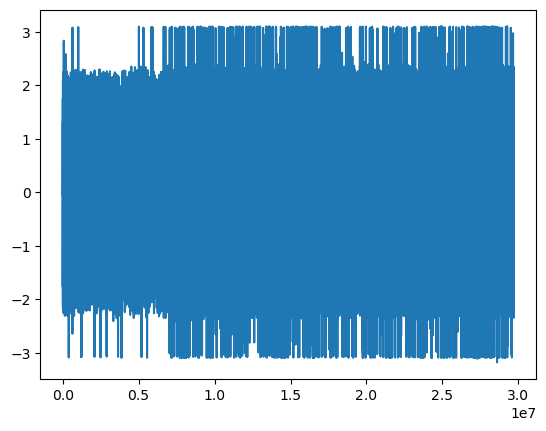

In [75]:
L2 = ngs.L2(mesh, dim=3, order = 3)
BB = ngs.GridFunction(L2)

B = fun_dw(normH)/normH*H
# B = fun_dw(H)

with ngs.TaskManager(): BB.Set(B)
BBnp = BB.vec.FV().NumPy()


import matplotlib.pyplot as plt
import numpy as np
print(max(abs(BBnp)))

plt.plot((BBnp))

In [76]:
Draw(B, mesh, clipping={"z":-1, "dist":0.064})
B[0]